# ICS 438 Project: Fake News
## by: Leilani Reich

### GitHub Repo: https://github.com/leilani-reich/ICS438-FinalProject-FakeNews

## Introduction

#### Problem Domain

The problem I'm tackling is classifying fake news. The domain of the problem includes news, natural language processing, and earth and nature.

#### Data Source and Description

Link to Dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=True.csv

Note: The dataset I'm using is titled "Fake and real news dataset" from user Clément Bisaillon on Kaggle.


Data Description:
There are two Comma Delimited Value (CSV) data files: Fake.csv (62.79 MB) and True.csv (53.58 MB).

Each data file contains the following 4 attributes for each record:

- title: the title of the article

- text: the text within the article 

- subject: the subject of the article

- date: the date at which the article was posted formatted as month, day year


#### Problems to tackle

I want to learn more about fake news and the characteristics that set it apart from true news.
This includes the length of fake news, the most prominent words in fake news vs true news, and
the dates at which fake vs true news are written. In the end, I want to use approximate nearest
neighbors to try and detect and classify fake news accurately.


## Install Libraries

In [ ]:
#!pip install pyspark
#!python -m pip install -U gensim
#%pip install -U sentence-transformers
#!pip install --user annoy
#!pip install faiss-cpu --no-cache
!pip install autofaiss

In [1]:
import pyspark.sql.functions as F
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_short
import re

In [2]:
# Create new Spark Context
from pyspark import SparkContext
sc = SparkContext()

In [3]:
# Create new Spark Session
from pyspark.sql import SparkSession
session = SparkSession(sc)

## Load in Data

In [4]:
# Some of the data like the text contains double quotes, which really cause a lot of issues!
# So I need escape='"'
fake_df = session.read.csv("Fake.csv", inferSchema = True, header=True, multiLine=True, escape='"')

print(type(fake_df))

print(fake_df.show())

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|
| Papa John’s Foun...|A centerpiece of ...|   Ne

In [5]:
fake_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [6]:
true_df = session.read.csv("True.csv", inferSchema = True, header=True, multiLine=True, escape='"')

print(type(true_df))

print(true_df.show())

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |
|White House, Cong...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Trump says Russia...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Factbox: Trump on...|The following sta...|politicsNews|December 29, 2017 |
|Trump on Twitter ...|The following sta...|politicsNews|December 29, 2017 |
|Alabama official ...|WASHINGTON (Reute...|pol

In [7]:
true_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



## Preprocess Data

### Remove missing info

In [ ]:
# Remove missing info if any

print("True title null:", true_df.filter(F.col("title").isNull()).count())
print("Fake title null:", fake_df.filter(F.col("title").isNull()).count())

print("True title nan:", true_df.filter(F.isnan(F.col("title"))).count())
print("Fake title nan:", fake_df.filter(F.isnan(F.col("title"))).count())

print("True text null:", true_df.filter(F.col("text").isNull()).count())
print("Fake text null:", fake_df.filter(F.col("text").isNull()).count())

print("True text nan:", true_df.filter(F.isnan(F.col("text"))).count())
print("Fake text nan:", fake_df.filter(F.isnan(F.col("text"))).count())

print("True subject null:", true_df.filter(F.col("subject").isNull()).count())
print("Fake subject null:", fake_df.filter(F.col("subject").isNull()).count())

print("True subject nan:", true_df.filter(F.isnan(F.col("subject"))).count())
print("Fake subject nan:", fake_df.filter(F.isnan(F.col("subject"))).count())

print("True date null:", true_df.filter(F.col("date").isNull()).count())
print("Fake date null:", fake_df.filter(F.col("date").isNull()).count())

print("True date nan:", true_df.filter(F.isnan(F.col("date"))).count())
print("Fake date nan:", fake_df.filter(F.isnan(F.col("date"))).count())

# I didn't detect any missing data but just to be safe

fake_df = fake_df.dropna()
true_df = true_df.dropna()


### Visualize the subjects/types of fake news by frequency

In [ ]:
import matplotlib.pyplot as plt

# Visualize the types of fake news by frequency

# Get the unique subject names for the articles
fake_news_types = fake_df.select("subject").distinct()
fake_news_types = list(fake_news_types.toPandas()["subject"])
print("fake news types", fake_news_types)

# Get the total counts for each type of article
fake_news_types_counts = fake_df.groupBy("subject").count().select("count")
fake_news_types_counts = list(fake_news_types_counts.toPandas()["count"])
print("fake news types counts:", fake_news_types_counts)

# Show subject names and corresponding counts in table
fake_df.groupBy("subject").count().show()

# Create dictionary with subjects as keys and counts as values
fake_news_dict = dict(zip(fake_news_types, fake_news_types_counts))

# Sort in ascending order by value
fake_news_by_frequency = sorted(fake_news_dict.items(), key=lambda x: x[1], reverse=True)

# Get sorted keys and values
fn_subjects, fn_counts = zip(*fake_news_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_subjects, height = fn_counts)

plt.xticks(rotation=-45)

plt.tight_layout()

plt.xlabel("Subject")
plt.ylabel("Count")

plt.title("Subjects of Fake News by Frequency")

plt.show()

### Visualize the subjects/types of true news by frequency

In [ ]:
# Visualize the types of true news by frequency

# Get the unique subject names for the articles
true_news_types = true_df.select("subject").distinct()
true_news_types = list(true_news_types.toPandas()["subject"])
print("true news types", true_news_types)

# Get the total counts for each type of article
true_news_types_counts = true_df.groupBy("subject").count().select("count")
true_news_types_counts = list(true_news_types_counts.toPandas()["count"])
print("true news types counts:", true_news_types_counts)

# Show subject names and corresponding counts in table
true_df.groupBy("subject").count().show()

# Create dictionary with subjects as keys and counts as values
true_news_dict = dict(zip(true_news_types, true_news_types_counts))

# Sort in ascending order by value
true_news_by_frequency = sorted(true_news_dict.items(), key=lambda x: x[1], reverse=True)

# Get sorted keys and values
fn_subjects, fn_counts = zip(*true_news_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_subjects, height = fn_counts)

plt.xticks(rotation=-45)

plt.tight_layout()

plt.xlabel("Subject")
plt.ylabel("Count")

plt.title("Subjects of Fake News by Frequency")

plt.show()


### Visualizing the top 20 most prominent dates of fake news

In [ ]:
# Visualizing the top 20 most prominent dates of fake news

# Get the unique dates for the articles
fake_news_dates = fake_df.select("date").distinct()
fake_news_dates = list(fake_news_dates.toPandas()["date"])
#print("fake news dates", fake_news_dates)

# Get the total counts for each type of article
fake_news_dates_counts = fake_df.groupBy("date").count().select("count")
fake_news_dates_counts = list(fake_news_dates_counts.toPandas()["count"])
#print("fake news dates counts:", fake_news_dates_counts)

# Show dates and corresponding counts in table
fake_df.groupBy("date").count().show()

# Create dictionary with subjects as keys and counts as values
fake_news_dict = dict(zip(fake_news_dates, fake_news_dates_counts))

# Sort in ascending order by value
fake_news_dates_by_frequency = sorted(fake_news_dict.items(), key=lambda x: x[1], reverse=True)

print("Top 20 most prevalent dates of fake news posts", list(fake_news_dict.items())[:10])

# Get sorted keys and values
fn_dates, fn_counts = zip(*fake_news_dates_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_dates[:20], height = fn_counts[:20])

plt.xticks(rotation=-90)

plt.title("Top 20 most prevalent dates of fake news posts")

plt.xlabel("Date")
plt.ylabel("Number of posts")

plt.tight_layout()

plt.show()

In [ ]:
# Visualizing the top 20 most prominent dates of true news

# Get the unique dates for the articles
true_news_dates = true_df.select("date").distinct()
true_news_dates = list(true_news_dates.toPandas()["date"])
#print("true news dates", true_news_dates)

# Get the total counts for each type of article
true_news_dates_counts = true_df.groupBy("date").count().select("count")
true_news_dates_counts = list(true_news_dates_counts.toPandas()["count"])
#print("true news dates counts:", true_news_dates_counts)

# Show dates and corresponding counts in table
true_df.groupBy("date").count().show()

# Create dictionary with subjects as keys and counts as values
true_news_dict = dict(zip(true_news_dates, true_news_dates_counts))

# Sort in ascending order by value
true_news_dates_by_frequency = sorted(true_news_dict.items(), key=lambda x: x[1], reverse=True)

print("Top 20 most prevalent dates of true news posts", list(true_news_dict.items())[:10])

# Get sorted keys and values
fn_dates, fn_counts = zip(*true_news_dates_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_dates[:20], height = fn_counts[:20])

plt.xticks(rotation=-90)

plt.title("Top 20 most prevalent dates of true news posts")

plt.xlabel("Date")
plt.ylabel("Number of posts")

plt.tight_layout()

plt.show()

## Lengths of fake vs real news
- Assumption: fake news is longer

### Comparing lengths of titles for fake and true news

In [ ]:
# Comparing lengths of title of posts for fake and true news
import pyspark.sql.functions as F

# Fake news average title length
fake_news_length = fake_df.withColumn("title_length", F.length(fake_df.title))
fake_news_title_avg = fake_news_length.agg(F.avg(F.col("title_length"))).first()[0]

# True news average title length
true_news_length = true_df.withColumn("title_length", F.length(true_df.title))
true_news_title_avg = true_news_length.agg(F.avg(F.col("title_length"))).first()[0]

print("Fake news title average length:", fake_news_title_avg)
print("True news title average length:", true_news_title_avg)

# Show subject names and corresponding counts in barchart
plt.bar(x = ["fake news title avg length", "true news title avg length"], height = [fake_news_title_avg, true_news_title_avg])

plt.xticks(rotation=0)

plt.title("Comparing average length of titles for fake and true news")

plt.xlabel("Type of news")
plt.ylabel("Average title length in characters")

plt.tight_layout()

plt.show()

### Comparing lengths of titles for fake and true news

In [ ]:
# Comparing lengths of text of posts for fake and true news

# Fake news average text length
fake_news_length = fake_df.withColumn("text_length", F.length(fake_df.text))
fake_news_text_avg = fake_news_length.agg(F.avg(F.col("text_length"))).first()[0]

# True news average title length
true_news_length = true_df.withColumn("text_length", F.length(true_df.text))
true_news_text_avg = true_news_length.agg(F.avg(F.col("text_length"))).first()[0]

print("Fake news text average length:", fake_news_text_avg)
print("True news text average length:", true_news_text_avg)

# Show subject names and corresponding counts in barchart
plt.bar(x = ["fake news text avg length", "true news text avg length"], height = [fake_news_text_avg, true_news_text_avg])

plt.xticks(rotation=0)

plt.title("Comparing average length of text for fake and true news")

plt.xlabel("Type of news")
plt.ylabel("Average text length in characters")

plt.tight_layout()

plt.show()

## Preprocessing Text Data

### Cleaning function

In [8]:
# Preprocess the text data
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_short, strip_numeric
import re

# Do some common cleaning options to remove noise from text
def clean_text(text):
    
    # Code from: https://stackoverflow.com/questions/640001/how-can-i-remove-text-within-parentheses-with-a-regex
    # by user Can Berk Güder, and this regex removes words in parentheses, ex. @(twitterName)
    text_reg1 = re.sub(r'\([^)]*\)', '', text)
     
    # This code comes from https://stackoverflow.com/questions/53071255/how-to-remove-urls-without-http-in-a-text-document-using-r
    # from user Wiktor Stribiżew and is used to remove URLs which may not have http in them
    text_reg2 = re.sub("\\s*[^ /]+/[^ /]+","", text_reg1)
    
    text_p1 = remove_stopwords(text_reg2)
    text_p2 = strip_punctuation(text_p1)
    text_p3 = strip_short(text_p2)
    
    # A lot of dates repeating like (Dec 2017), so I removed numbers to try and remove this redundancy
    text_p4 = strip_numeric(text_p3)
    
    return text_p4.lower()


### Cleaning and arranging text data for fake news

In [9]:
# Cleaning and arranging text data for fake news

print("Before Cleaning:\n", fake_df.select("text").first())

# I combined the title and text and am considering them together and applying cleaning to each
fake_text = fake_df.rdd.map(lambda x: clean_text(x["title"]) + " " + clean_text(x["text"]))
print(type(fake_text))

print("\n After Cleaning:\n", fake_text.first())

Before Cleaning:
 Row(text='Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! H

### Cleaning and arranging text data for fake news

In [10]:
# Cleaning and arranging text data for true news

print("Before Cleaning:\n", true_df.select("text").first())

# I combined the title and text and am considering them together
true_text = true_df.rdd.map(lambda x: clean_text(x["title"])+ " " + clean_text(x["text"]))
print(type(true_text))

print("\n After Cleaning:\n", true_text.first())

Before Cleaning:
 Row(text='WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on p

### Load in news text as spark dataframes and add column for the type of news (fake or true)

In [11]:
# Load in news text as spark dataframes and add column for the type of news (fake or true)
from pyspark.sql.functions import lit
from pyspark.sql import Row

fake_text_df = fake_text.map(Row("value")).toDF()
# adding new column for class_name, which is all "fake"
fake_text_df = fake_text_df.withColumn("class_name", lit("fake"))

true_text_df = true_text.map(Row("value")).toDF()
# adding new column for class_name, which is all "true"
true_text_df = true_text_df.withColumn("class_name", lit("true"))

print(fake_text_df.columns)
print(true_text_df.columns)

['value', 'class_name']
['value', 'class_name']


### Combine the fake news and true news dataframes into one

In [12]:
# Combine the dataframes into one
import pyspark.sql.functions as F

news_text_df = fake_text_df.union(true_text_df)

news_text_df = news_text_df.coalesce(4)

# make the order of fake/true news random
news_text_df = news_text_df.select("*").orderBy(F.rand())

#print(news_text_df.rdd.getNumPartitions())

news_text_df.show()

+--------------------+----------+
|               value|class_name|
+--------------------+----------+
|senate candidate ...|      true|
|naacp members arr...|      fake|
|alan dershowitz s...|      fake|
|white house staff...|      true|
|claims votes dead...|      true|
|former trump aide...|      fake|
|hezbollah leader ...|      true|
|revolution coming...|      fake|
|watch trey gowdy ...|      fake|
|following trump w...|      true|
|turkey wants iraq...|      true|
|busted anti trump...|      fake|
|republican’s excu...|      fake|
|hillary clinton’s...|      fake|
|mom hears old dau...|      fake|
|welcomes china so...|      true|
|naacp bannon may ...|      fake|
|watch kieth scott...|      fake|
|the obamas honor ...|      fake|
|spanish national ...|      true|
+--------------------+----------+
only showing top 20 rows



## Get words with highest tf-idfs for types of news

### Compute TF-IDF using Pyspark library HashingTF and IDF

In [ ]:
# Let's get the tf-idf to see the most common words
# https://spark.apache.org/docs/latest/mllib-feature-extraction.html

from pyspark.ml.feature import HashingTF, IDF, Tokenizer

# Start by tokenizing text
tokenizer = Tokenizer(inputCol="value", outputCol="tokens")
news_text_tokenized = tokenizer.transform(news_text_df)

news_text_tokenized.show()


In [ ]:
# Computing the tf-idf

# Code set up using Spark documentation https://spark.apache.org/docs/latest/mllib-feature-extraction.html

hashingTF = HashingTF(inputCol="tokens", outputCol="raw_features")
tf = hashingTF.transform(news_text_tokenized)

#tf.cache()
idf = IDF(inputCol="raw_features", outputCol="features").fit(tf)
tfidf = idf.transform(tf)

tfidf.select(["class_name", "tokens", "features"]).show()


In [ ]:
# What does the data look like?

print(type(tfidf.select("features").first()))

print(tfidf.select("features").first())

In [ ]:
# Get most important words according to tf-idf

from pyspark.sql.types import ArrayType, DoubleType, StringType, MapType

# I used code from stackoverflow and applied it to my data:
# source - https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document

ndf = tfidf.select('class_name',F.explode('tokens').name('exptokens')).withColumn('tokens',F.array('exptokens'))
hashudf = F.udf(lambda vector : vector.indices.tolist()[0],StringType())
wordtf = hashingTF.transform(ndf).withColumn('wordhash',hashudf(F.col('raw_features')))
wordtf.show()

In [ ]:
# I used code from stackoverflow and applied it to my data:
# source - https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document# 

udf1 = F.udf(lambda vec : dict(zip(vec.indices.tolist(),vec.values.tolist())),MapType(StringType(),StringType()))
valuedf = tfidf.select('class_name',F.explode(udf1(F.col('features'))).name('wordhash','value'))
valuedf.show()

In [ ]:
from pyspark.sql import Window

# I used code from stackoverflow and applied it to my data:
# source - https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document# 

w = Window.partitionBy("class_name").orderBy(F.desc('value'))
valuedf = valuedf.withColumn('rank',F.rank().over(w)).where(F.col('rank')<=3) # used 3 for testing.

topn_df = valuedf.join(wordtf,['class_name','wordhash']).groupby('class_name').agg(F.sort_array(F.collect_list(F.struct(F.col('value'),F.col('exptokens'))),asc=False).name('topn')
                                                                                   
                                                                                   
                                                                                   

topn_df.show()

In [ ]:
#print(topn_df.first()[1])

# Dungeons, descent, macy are top words for fake news??

## Split Data

In [13]:
import numpy as np

# Setting up for embedding for news text:

# Splitting data into train and test
news_text_train_df, news_text_test_df = news_text_df.randomSplit([0.9, 0.1])

# Double check randomsplit gives what we expect
news_train_len = news_text_train_df.count()
news_test_len = news_text_test_df.count()
total_len = news_train_len + news_test_len

print("Percent training:", round(news_train_len / total_len, 2))
print("Percent testing:", round(news_test_len / total_len, 2))


Percent training: 0.9
Percent testing: 0.1


## Can we classify news as being fake or true?

- use classes of sentences closest to query to assign class to query
- and what sentences are closest to query?

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, NGram, BucketedRandomProjectionLSH

# Create a pipeline
model = Pipeline(stages=[
    # Create tokens from words
    Tokenizer(inputCol="value", outputCol="tokens"),
    # Get ngrams from tokens (speeds up computation)
    NGram(n=8, inputCol="tokens", outputCol="ngrams"),
    # Get feature vectors to input to LSH
    HashingTF(inputCol="ngrams", outputCol="vectors"),
]).fit(news_text_train_df)

news_text_trans = model.transform(news_text_train_df)

In [ ]:
# Create LSH model Bucket Random Projection (https://spark.apache.org/docs/2.2.3/ml-features.html#lsh-operations)
LSH_model = BucketedRandomProjectionLSH(inputCol="vectors", outputCol="lsh", bucketLength=2.0, numHashTables=3).fit(news_text_trans)

LSH_model.transform(news_text_trans).show()

In [ ]:
# Double check what columns were for test set
print(news_text_test_df.columns)

In [ ]:
keys = model.transform(news_text_test_df)

print(type(keys.first()[4]))
print(keys.columns)

In [ ]:
#key = model.transform(news_text_test_df.first()[0])

result = LSH_model.approxNearestNeighbors(news_text_trans, keys.first()[4], 5)


In [ ]:
# Get counts of how many neighbors were from the fake news class and the true news class
class_name_counts = result.groupBy("class_name").count()

# First index of keys.first() is class_name
print("Real class:", keys.first()[1])
# Get class with max count from neighbors
print("Predicted class:", class_name_counts.first()[0])

In [ ]:
from pyspark.sql.types import StringType

# Get metrics for model like precision, recall, auc

# def pred_class(key):
#     result = LSH_model.approxNearestNeighbors(news_text_trans, key, 5)
#     class_name_counts = result.groupBy("class_name").count()
#     return class_name_counts.first()[0]

# udf_pred_class = udf(pred_class, StringType())

key_list = keys.take(1)

print("done keys")

correct_preds = 0
for i in range(1):
    result = LSH_model.approxNearestNeighbors(news_text_trans, key_list[i][4], 5)
    print("approxNN done")
    class_name_count = result.groupBy("class_name").count()
    print(class_name_count)
    print("groupBy done")
    # pred_class = class_name_counts.first()[0]
    # real_class = key_list[i][1]
    # print("Predicted class:", pred_class)
    # print("Actual class:", real_class)
    # if (pred_class == real_class):
    #     correct_preds += 1
    # print("correct predictions:", correct_preds, "\n")


## Using Autofaiss

In [14]:
# Embed with sentence transformer here

# Create SentenceTransformer model

from sentence_transformers import SentenceTransformer

# https://www.sbert.net/docs/pretrained_models.html
ST_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

In [15]:
# Create embeddings

print("Embedding Dimension:", ST_model.encode(fake_text.first()).reshape(1, -1).shape)

Embedding Dimension: (1, 384)


In [ ]:
# Embed the training text

# # Converting numpy to list because pyspark cannot handle numpy
# news_embed_train = news_text_train_df.rdd.map(lambda x: (x["class_name"], ST_model.encode(x["value"]).tolist()))

# print("done a")

# news_embed_train = news_embed_train.toDF(("class_name", "text"))

# print("done b")

# #fake_embed_train = news_embed_train.filter(lambda x: x[0] == "fake")

# #true_embed_train = news_embed_train.filter(lambda x: x[0] == "true")

# # # Don't embed test
# # # just use news_text_test_df

# print(news_embed_train.take(1))

# #print(type(fake_embed_train))
# #print(type(true_embed_train))

In [16]:
news_text_train_df = news_text_train_df.sample(0.01)

In [18]:
# Save data to csv, load csv with dask

news_text_train_df.coalesce(1).write.option("header", "true").csv("news_text_train2.csv")

In [19]:
import dask.dataframe as dd
from glob import glob

path = glob('news_text_train2.csv/*.csv')
print(path)

news_train_dask_df = dd.read_csv(path)

['news_text_train2.csv/part-00000-62907511-4492-4706-86be-8612ab5d5c65-c000.csv']


In [ ]:
#news_train_dask_df2 = dd.DataFrame.sample(news_train_dask_df, frac=0.01)

In [ ]:
#news_train_dask_df2.head()

In [20]:
import dask.array as da
import os

f = open("testing/test.npy", "wb")

my_arr = np.empty((1,384), dtype='float64')
my_labels = []

#os.mkdir("testing")
def nump(arr, x):
    x = ST_model.encode(x)
    
    return np.append(arr, x.reshape(1,384), axis=0)
    
    
# Converts to pandas - try batching?

for i in news_train_dask_df['value'].compute():    
    my_arr = nump(my_arr, i)
    
for i in news_train_dask_df['class_name'].compute():    
    my_labels.append(i)

    
my_arr_test = []#np.empty((1,384), dtype='float64')
my_labels_test = []


news_test = news_text_test_df.toPandas()

for i in news_test["value"]:    
    #my_arr_test = nump(my_arr_test, i)
    #my_arr_test = np.append(my_arr_test, i)
    my_arr_test.append(i)
    
for i in news_test["class_name"]:   
    my_labels_test.append(i)



f.flush()

f.close()

In [22]:
print(my_arr_test[0])

np.save('testing/test.npy', my_arr)

#print(my_arr_test[0])

abc news reports las vegas massacre suspect’s hard drive missing from his laptop the investigation las vegas massacre stephen paddock keeps getting strange since shooting massacre took lives injured hundreds las vegas country music festival seen timeline changes lockdown las vegas coroner office strange protection security guard mandalay bay casino resort including armed guard scripted appearance ellen show and like well known mass shooters him stephen paddock hard drive missing abc news laptop recovered las vegas hotel room stephen paddock launched deadliest mass shooting history missing hard drive depriving investigators potential key source information killed maimed people abc news learned paddock believed removed hard drive fatally shooting himself missing device recovered sources told abc news investigators digging paddock background learned purchased software designed erase files hard drive hard drive examine impossible know software source said the absence substantial digital cl

In [23]:
# I am using autofaiss, with guidance on the documentation
# from https://github.com/criteo/autofaiss

import os
import numpy as np
import dask.array as da
#os.mkdir("news_train_embeddings")

#os.mkdir("my_index_folder")

In [24]:
!autofaiss build_index --embeddings="testing/" --index_path="my_index_folder/knn.index" --index_infos_path="my_index_folder/index_infos.json" --metric_type="ip"

2022-12-15 11:06:32,595 [INFO]: Using 8 omp threads (processes), consider increasing --nb_cores if you have more
2022-12-15 11:06:32,596 [INFO]: Launching the whole pipeline 12/15/2022, 11:06:32
2022-12-15 11:06:32,596 [INFO]: Reading total number of vectors and dimension 12/15/2022, 11:06:32
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 411.85it/s]
2022-12-15 11:06:32,673 [INFO]: There are 422 embeddings of dim 384
2022-12-15 11:06:32,673 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 0.0775 secs
2022-12-15 11:06:32,674 [INFO]: 	Compute estimated construction time of the index 12/15/2022, 11:06:32
2022-12-15 11:06:32,674 [INFO]: 		-> Train: 16.7 minutes
2022-12-15 11:06:32,674 [INFO]: 		-> Add: 0.0 seconds
2022-12-15 11:06:32,674 [INFO]: 		Total: 16.7 minutes
2022-12-15 11:06:32,674 [INFO]: 	>>> Finished "Compute estimated construction time of the index" in 0.0006 secs
2022-12-15 11:06:32,674 [INFO]: 	Checking that your have enough memor

In [26]:
# Using autoFAISS, documentation here https://github.com/criteo/autofaiss

import faiss
import glob
import numpy as np

my_index = faiss.read_index(glob.glob("my_index_folder/*.index")[0])

key = news_text_test_df.select("value").take(1)[0][0]

print(key)


abc news reports las vegas massacre suspect’s hard drive missing from his laptop the investigation las vegas massacre stephen paddock keeps getting strange since shooting massacre took lives injured hundreds las vegas country music festival seen timeline changes lockdown las vegas coroner office strange protection security guard mandalay bay casino resort including armed guard scripted appearance ellen show and like well known mass shooters him stephen paddock hard drive missing abc news laptop recovered las vegas hotel room stephen paddock launched deadliest mass shooting history missing hard drive depriving investigators potential key source information killed maimed people abc news learned paddock believed removed hard drive fatally shooting himself missing device recovered sources told abc news investigators digging paddock background learned purchased software designed erase files hard drive hard drive examine impossible know software source said the absence substantial digital cl

In [ ]:
label = news_text_test_df.select("class_name").take(1)[0][0]

print(label)

In [36]:
from collections import Counter

#distances, indices = my_index.search(ST_model.encode(my_arr_test[1]).reshape(1,384), 5)

preds = []
for key in my_arr_test:
    distances, indices = my_index.search(ST_model.encode(key).reshape(1, 384), 5)

    classes = []
    for i in indices[0]:
        # if (i > 420):
        #     print(i)
        #     break
        classes.append(my_labels[i-1])

    class_counter = Counter(classes)
    preds.append(class_counter.most_common(1)[0][0])

In [45]:
#print(list(zip(distances[0,0], indices[0,0])))

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(my_labels_test, preds)
print(conf_mat)

[[1947  407]
 [ 278 1981]]


<AxesSubplot:>

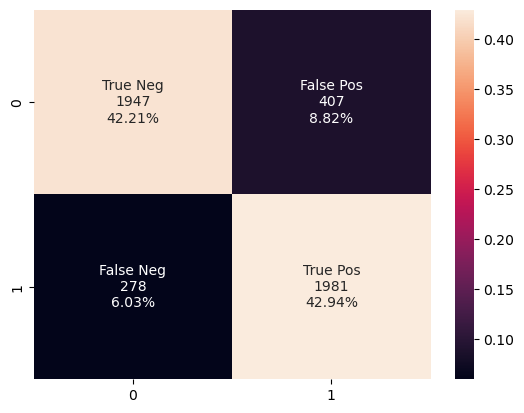

In [56]:
import seaborn as sn

# Using https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
# for formatting the confusion matrix

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(conf_mat/np.sum(conf_mat), fmt='', annot=labels)

## Metrics for ANN Model

In [92]:
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

TN, FP, FN, TP = conf_mat.flatten()

# Formulas from https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124
# by Salma Ghoneim

accuracy = (TP + TN) / (TP + FP + FN + TN)

precision = TP / (TP + FP)

recall = TP / (TP + FN)

specificity = TN / (TN + FP)

f1_score = 2 * (recall * precision) / (recall + precision)


# Convert fake to 0, true to 1 to pass to roc_curve and auc functions
my_labels_test_num = [0 if i == "fake" else 1 for i in my_labels_test]

my_preds_num = [0 if i == "fake" else 1 for i in preds]

fpr, tpr, thresholds = metrics.roc_curve(my_labels_test_num, my_preds_num, pos_label = 1)

auc_score = metrics.auc(fpr, tpr)

print("Metrics:\n",
      f"   Accuracy: {accuracy}\n",
      f"  Precision: {precision}\n",
      f"     Recall: {recall}\n",
      f"Specificity: {specificity}\n",
      f"   F1 Score: {f1_score}\n",
      f"        AUC: {auc_score}")

Metrics:
    Accuracy: 0.8515066117494039
   Precision: 0.8295644891122278
      Recall: 0.8769366976538291
 Specificity: 0.8271028037383178
    F1 Score: 0.8525930707983645
         AUC: 0.8520197506960734


## Conclusions

Fake news is longer than true news, which was my initial hypothesis.